In [1]:
import numpy,os,sklearn
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as sms
import pydicom as dicom

import utils

# Image Data

## Suspicious Mammographies (BCDR-D01 & BCDR-D02)

### CSV Analysis

In [2]:
bcdr1_raw = pd.read_csv('d:/BCDR/BCDR-D01_dataset/bcdr_d01_img.csv')
bcdr1_raw = bcdr1_raw.drop_duplicates(subset=['image_filename'],keep='first',ignore_index=True)
bcdr1_raw= utils.fix_view(bcdr1_raw,'image_type_name')
bcdr1_features_raw = pd.read_csv('D:\BCDR\BCDR-D01_dataset/bcdr_d01_features.csv')
bcdr2_raw = pd.read_csv('d:/BCDR/BCDR-D02_dataset/bcdr_d02_img.csv')
bcdr2_raw = bcdr2_raw.drop_duplicates(subset=['image_filename'],keep='first',ignore_index=True)
bcdr2_raw= utils.fix_view(bcdr2_raw,'image_type_name')
bcdr2_features_raw = pd.read_csv('D:\BCDR\BCDR-D02_dataset/bcdr_d02_features.csv')
l1 = utils.lesion_findings(bcdr1_features_raw)
l2 = utils.lesion_findings(bcdr2_features_raw)

In [3]:
bcdr1 = bcdr1_raw[['patient_id','study_id','image_filename','image_type_name','density','age']]
bcdr1_features= bcdr1_features_raw[['patient_id','study_id','image_view','s_x_center_mass','s_y_center_mass','density','age']]

bcdr1 = utils.merge_csv(bcdr1_features,bcdr1)
bcdr1['lesion_type'] = l1

C:\Users\pvila\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\pvila\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\pvila\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [4]:
bcdr2 = bcdr2_raw[['patient_id','study_id','image_filename','image_type_name','density','age']]
bcdr2_features= bcdr2_features_raw[['patient_id','study_id','image_view','s_x_center_mass','s_y_center_mass','density','age']]

bcdr2 = utils.merge_csv(bcdr2_features,bcdr2)
bcdr2['lesion_type'] = l2

C:\Users\pvila\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
lesion_mammographies1 = pd.DataFrame({})
lesion_mammographies1[['patient_id','image_view','image_path','x_center','y_center','density','age','lesion_type']] = bcdr1[['patient_id','image_view','image_filename','s_x_center_mass','s_y_center_mass','density','age','lesion_type']]
new_patients = []
for patient in list(lesion_mammographies1['patient_id']):
    patient_n= '1d'+str(patient)
    new_patients.append(patient_n)
lesion_mammographies1['patient_id'] = new_patients
lesion_mammographies1 = utils.fix_bcdr1_path(lesion_mammographies1,'image_path')

In [6]:
lesion_mammographies2 = pd.DataFrame({})
lesion_mammographies2[['patient_id','image_view','image_path','x_center','y_center','density','age','lesion_type']] = bcdr2[['patient_id','image_view','image_filename','s_x_center_mass','s_y_center_mass','density','age','lesion_type']]
new_patients = []
for patient in list(lesion_mammographies2['patient_id']):
    patient_n= '2d'+str(patient)
    new_patients.append(patient_n)
lesion_mammographies2['patient_id'] = new_patients
lesion_mammographies2 = utils.fix_bcdr2_path(lesion_mammographies2,'image_path')
lesion_mammographies2 = lesion_mammographies2[:100]

In [7]:
lesion_mammographies = pd.concat([lesion_mammographies1,lesion_mammographies2],ignore_index=True)
lesion_mammographies = utils.fix_view_back(lesion_mammographies,'image_view')
print('Suspicious Dataset: ',lesion_mammographies.shape)

Suspicious Dataset:  (243, 8)


### Split and Copy

In [8]:
sus_training,sus_validation = sms.train_test_split(lesion_mammographies,test_size=0.35)

In [ ]:
utils.image_mover(sus_training,'image_data/raw/training/suspicious')
utils.image_mover(sus_validation,'image_data/raw/validation/suspicious')

## Normal Mammographies (BCDR-DN01 & INbreast)

### CSV Analysis

In [11]:
bcdrN = pd.read_csv('d:/BCDR/BCDR-DN01_dataset/bcdr_dn01_img.csv')

In [12]:
normal_mammographies1 = pd.DataFrame({})
normal_mammographies1[['patient_id','image_view','image_path','density','age']] = bcdrN[['patient_id','image_type_name','image_filename','density','age']]
normal_mammographies1 = utils.fix_bcdrN_path(normal_mammographies1,'image_path')

In [13]:
xls_raw = pd.read_excel('D:/INBreast/INbreast.xls')
xls = pd.DataFrame()
xls['image_view'] = [xls_raw['Laterality'][i] + xls_raw['View'][i] for i in xls_raw.index] 
xls[['filename','finding notes']] = xls_raw[['File Name','Findings Notes (in Portuguese)']]

In [14]:
path_list = os.listdir('D:/INBreast/AllDICOMs/')
r = []
for path in path_list:
    if path[-3:] != 'dcm':
        r.append(path)
for i in r:
    path_list.remove(i)

In [15]:
patients = []
file_paths = []
image_views = []
for path in path_list:
    l = path.split('_')
    if len(l) > 1:
        patients.append(l[1])
        file_paths.append(path)
        image_views.append(l[3]+l[4])
images_df = pd.DataFrame({'patient_id':patients,'image_view':image_views,'image_path':file_paths})
images_df = utils.fix_inbreast_path(images_df,'image_path')

In [16]:
images_df[['finding notes']] = xls[['finding notes']]
normal_df = images_df[images_df['finding notes'] == 'normal']
normal_mammographies2 = pd.DataFrame()
normal_mammographies2[['patient_id','image_view','image_path']] = normal_df[['patient_id','image_view','image_path']]

In [17]:
normal_mammographies = pd.concat([normal_mammographies1,normal_mammographies2],ignore_index=True)
print('Normal Dataset: ',normal_mammographies.shape)

Normal Dataset:  (255, 5)


### Split and Copy

In [18]:
normal_training,normal_validation = sms.train_test_split(normal_mammographies,test_size=0.35)

In [21]:
normal_training

,patient_id,image_view,image_path,density,age
49,41,LCC,d:/BCDR/BCDR-DN01_dataset/patient_41/study_57/...,3.0,53.0
86,71,RCC,d:/BCDR/BCDR-DN01_dataset/patient_71/study_793...,3.0,73.0
118,87,RO,d:/BCDR/BCDR-DN01_dataset/patient_87/study_119...,1.0,68.0
146,101,RO,d:/BCDR/BCDR-DN01_dataset/patient_101/study_13...,3.0,56.0
59,52,LO,d:/BCDR/BCDR-DN01_dataset/patient_52/study_74/...,2.0,34.0
...,...,...,...,...,...
97,75,RO,d:/BCDR/BCDR-DN01_dataset/patient_75/study_103...,2.0,54.0
112,87,RCC,d:/BCDR/BCDR-DN01_dataset/patient_87/study_118...,1.0,66.0
35,28,LO,d:/BCDR/BCDR-DN01_dataset/patient_28/study_39/...,3.0,50.0
219,069212ec65a94339,LML,d:/INBreast/AllDICOMs/50994733_069212ec65a9433...,NaN,NaN


In [30]:
ids = sus_training['patient_id']
a = 0
for i in ids:
    if str(i)[:2] == '1d':
        a += 1
a

94

In [ ]:
utils.image_mover(normal_training,'image_data/raw/training/normal')
utils.image_mover(normal_validation,'image_data/raw/validation/normal')

## Windowing

In [ ]:
medical_image = dicom.read_file(list(normal_mammographies2['image_path'])[0])

In [ ]:
image = medical_image.pixel_array
plt.imshow(image,cmap='gray')

In [ ]:
hu_image = transform_to_hu(medical_image,image)
plt.imshow(hu_image)

In [ ]:
brain_image = window_image(hu_image, 60, 100)
plt.imshow(brain_image,cmap='gray')

In [ ]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def transform_to_hu(medical_image, image):
    intercept = -1024
    slope = 1
    hu_image = image * slope + intercept

    return hu_image

## Age

In [ ]:
dfs = pd.concat([normal_mammographies,lesion_mammographies],ignore_index=True)

In [ ]:
a = 'numerical_data/features_training_suspicious.csv'
gt = pd.read_csv('image_data/csvs/training_suspicious.csv')
features_df = pd.read_csv(a)
ages = []
for i in gt.index:
    p = gt.loc[i,'Original']
    age_index = dfs[dfs['image_path'] == p].index
    age = dfs.loc[age_index,'age'].to_list()[0]
    ages.append(age)

In [ ]:
features_df['Age'] = ages
features_df.to_csv(a)

# Numerical Data

## Create Features Documents

In [ ]:
utils.mammary_features('image_data/raw/training/normal/','features_training_normal.csv')
utils.mammary_features('image_data/raw/training/suspicious/','features_training_suspicious.csv')
utils.mammary_features('image_data/raw/validation/normal/','features_validation_normal.csv')
utils.mammary_features('image_data/raw/validation/suspicious/','features_validation_suspicious.csv')

## Load Features Documents

In [ ]:
features_training_normal = pd.read_csv('numerical_data/features_training_normal.csv')
features_training_suspicious = pd.read_csv('numerical_data/features_training_suspicious.csv')
features_validation_normal = pd.read_csv('numerical_data/features_validation_normal.csv')
features_validation_suspicious = pd.read_csv('numerical_data/features_validation_suspicious.csv')

# Train Bird's Eye Model

## Crop Background and Downsample

In [ ]:
utils.downsample('image_data/raw/training/normal/','image_data/downsampled/training/normal/',1500,1100)
utils.downsample('image_data/raw/training/suspicious/','image_data/downsampled/training/suspicious/',1500,1100)
utils.downsample('image_data/raw/validation/normal/','image_data/downsampled/validation/normal/',1500,1100)
utils.downsample('image_data/raw/validation/suspicious/','image_data/downsampled/validation/suspicious/',1500,1100)

# Train Negatives Model

## Copy Negatives

In [ ]:
downsample = True

utils.copy_negatives('image_data/downsampled/training/normal/',downsample)
utils.copy_negatives('image_data/downsampled/training/suspicious/',downsample)
utils.copy_negatives('image_data/downsampled/validation/normal/',downsample)
utils.copy_negatives('image_data/downsampled/validation/suspicious/',downsample)

# Feature Extraction

In [ ]:
from_scratch_fe,transfer_fe = utils.create_feature_extraction(2000,1600)

In [ ]:
g1 = utils.generator_fe1(2000,1600)
g2 = utils.generator_fe2(2000,1600)

## From-Scratch

In [ ]:
X1 = from_scratch_fe.predict(g1,verbose=1)
y = g1.classes

In [ ]:
X1_train, X1_test,y_train, y_test = sms.train_test_split(X1,y,test_size=0.35,random_state=5)

In [ ]:
forest_model = RandomForestClassifier()
a = forest_model.fit(X1_train,y_train)

In [ ]:
y_pred = forest_model.predict_proba(X1_test)

In [ ]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_test,numpy.argmax(y_pred,axis=1))

plt.figure(figsize=(5, 5))
plt.imshow(c)

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        text = plt.text(j, i, c[i, j],
                       ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()


In [ ]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_test,ypred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_test,ypred)
plt.plot(fpr,tpr)
print('AUC:',auc)

In [ ]:
0/0

## Transfer Learning

In [ ]:
X2 = transfer_fe.predict(g2,verbose=1)
y = g2.classes

In [ ]:
X2_train, X2_test,y_train, y_test = sms.train_test_split(X2,y,test_size=0.35,random_state=5)

In [ ]:
forest_model = RandomForestClassifier()
a = forest_model.fit(X2_train,y_train)

In [ ]:
y_pred = forest_model.predict_proba(X2_test)

In [ ]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_test,numpy.argmax(y_pred,axis=1))

plt.figure(figsize=(5, 5))
plt.imshow(c)

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        text = plt.text(j, i, c[i, j],
                       ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.show()

In [ ]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_test,ypred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_test,ypred)
plt.plot(fpr,tpr)
print('AUC:',auc)

# Patching

In [ ]:
utils.save_patches_by_image('image_data/raw/training/normal/',300,0.2)
utils.save_patches_by_image('image_data/raw/training/suspicious/',300,0.2)
utils.save_patches_by_image('image_data/raw/validation/normal/',300,0.2)
utils.save_patches_by_image('image_data/raw/validation/suspicious/',300,0.2)

In [ ]:
utils.classify_patches('image_data/raw/training/normal/')
utils.classify_patches('image_data/raw/training/suspicious/')
utils.classify_patches('image_data/raw/validation/normal/')
utils.classify_patches('image_data/raw/validation/suspicious/')


In [ ]:
utils.add_to_features_csv('image_data/raw/training/normal/','numerical_data/features_training_normal.csv',0.4)
utils.add_to_features_csv('image_data/raw/training/suspicious/','numerical_data/features_training_suspicious.csv',0.4)
utils.add_to_features_csv('image_data/raw/validation/normal/','numerical_data/features_validation_normal.csv',0.4)
utils.add_to_features_csv('image_data/raw/validation/suspicious/','numerical_data/features_validation_suspicious.csv',0.4)

In [ ]:
utils.add_to_final_csv()

## Area Factor

In [ ]:
afs = []

In [ ]:
image_folder = 'image_data/raw/validation/suspicious/'
l = os.listdir(image_folder)
p = [str(n) for n in range(len(l))]
ps= []
for i in p:
    a = image_folder+i+'.bmp'
    ps.append(a)

area_factors = []

for image_path in ps:
    af = utils.breast_area_factor(image_path)
    area_factors.append(af)

afs = afs + area_factors


In [ ]:
r = pd.read_csv('numerical_data/classification_data_comp.csv')
r['Area Factor'] = afs
r.to_csv('numerical_data/classification_data_comp.csv',index=False)

# Meta Classification

## Evaluate Mammograms

In [ ]:
features_validation_normal['Ground Truth'] = 0
features_training_normal['Ground Truth'] = 0
features_training_suspicious['Ground Truth'] = 1
features_validation_suspicious['Ground Truth'] = 1

In [ ]:
dataframe = pd.concat([features_training_normal,features_training_suspicious,features_validation_normal,features_validation_suspicious],ignore_index=True)

In [ ]:
model = keras.models.load_model('models/mammo_comp.h5')

In [ ]:
utils.classify_mammograms(model,dataframe,True)

## CNN Results

In [2]:
comp = True

In [3]:
if comp:
    dataframe = pd.read_csv('numerical_data/classification_data_comp.csv')
else:
    dataframe = pd.read_csv('numerical_data/classification_data.csv')

In [4]:
data= utils.generator_transfer(1500,1100,False,False)
y_true = data[1].classes
y_pred = dataframe['Classifications'][-176:]

Found 322 images belonging to 2 classes.
Found 176 images belonging to 2 classes.


Sensitivity: 0.83
Specificity: 0.87


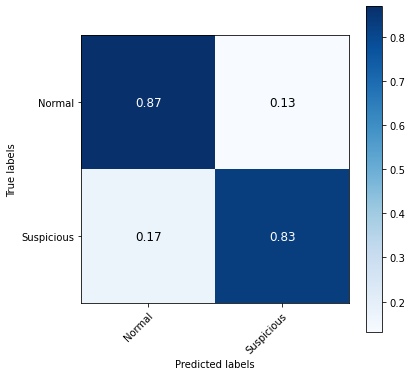

In [5]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_true,numpy.round(y_pred),normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(6, 6))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.savefig('full_img_cm.pdf')
plt.show()

In [6]:
acc = sklearn.metrics.accuracy_score(y_true,numpy.round(y_pred))
print('Accuracy:',acc)

Accuracy: 0.8465909090909091


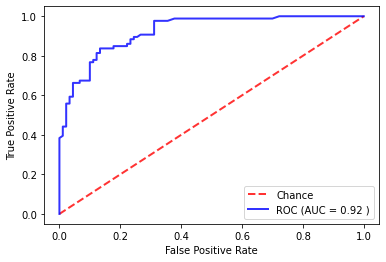

In [11]:
auc = sklearn.metrics.roc_auc_score(y_true,y_pred)
fpr,tpr,_= sklearn.metrics.roc_curve(y_true,y_pred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.savefig('full_img_ROC.pdf')
#print('AUC:',auc)

## Metaclassifier

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [3]:
comp = True

In [4]:
if comp:
    dataframe = pd.read_csv('numerical_data/classification_data_comp.csv')
else:
    dataframe = pd.read_csv('numerical_data/classification_data.csv')
dataframe = dataframe.sample(n=len(dataframe.index))

In [9]:
X = dataframe.loc[:, dataframe.columns != 'Ground Truth']
X = X.loc[:, X.columns != 'Unnamed: 0']
X = X.loc[:, X.columns != 'Unnamed: 0.1']
X = X.loc[:, X.columns != 'Ratio']
X = X.loc[:, X.columns != 'Ratios']
X = X.loc[:, X.columns != 'Area Factor']
#X = X.loc[:, X.columns != 'I_Kurtosis']
#X = X.loc[:, X.columns != 'I_Mode']
#X = X.loc[:, X.columns != 'I_Std']
#X = X.loc[:, X.columns != 'I_Median']
#X = X.loc[:, X.columns != 'T_Entropy']
#X = X.loc[:, X.columns != 'I_Skewness']
y = dataframe['Ground Truth']

In [10]:
my_imputer = SimpleImputer(strategy='constant',fill_value=56)
imputed_X_train_age = my_imputer.fit_transform(numpy.array(X['Age']).reshape(-1,1))
X['Age'] = imputed_X_train_age
X = X.astype({'Age': 'int32'})

In [11]:
X1 = X.rename(columns={'Ratios':'Patches_Norm'},inplace=False)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X1, y,test_size=0.35)
X1.head(5)

,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Age,Classifications
33,109.85482,46.27217,109.0,60,4.93134,0.13372,-1.16854,41,0.128
214,73.29609,33.68115,70.0,65,4.66742,0.35501,-0.03795,73,0.406
244,120.20673,37.16652,120.0,121,4.84269,0.19252,0.68514,59,0.892
266,117.74970,25.89137,121.0,121,4.42432,-0.39522,1.93249,64,1.000
305,143.70078,44.13737,153.0,179,4.94432,-0.37776,-0.73817,50,1.000


In [13]:
forest_model = RandomForestClassifier()
model = svm.SVC()
pipeline = Pipeline(steps=[('model',model)])
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_valid)
names = ['normal','suspicious']
#print(classification_report(y_valid, preds,target_names=names))

### Feature Importance

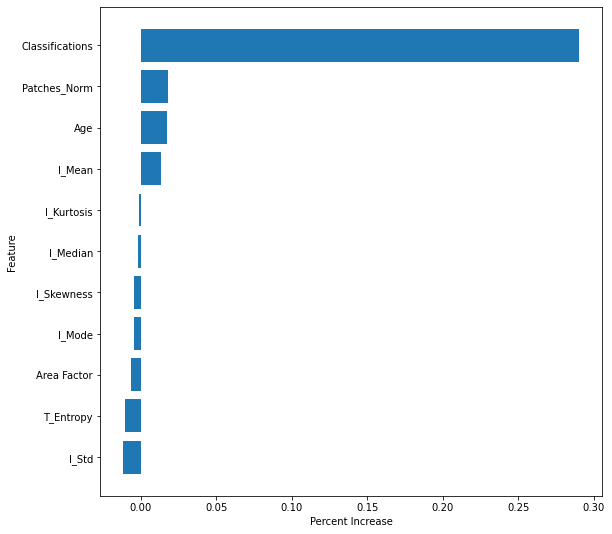

In [23]:
result = permutation_importance(forest_model, X_valid, y_valid, n_repeats=10)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(9,9))
plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Percent Increase')
plt.ylabel('Feature')
plt.savefig('both_RF_fi.pdf')

In [16]:
X_new = SelectKBest(f_classif, k=5).fit_transform(X, y)

### Parameter Optimization

#### Random Forest

In [ ]:
p = {'n_estimators':[50,100,500,1000,1500,2000],'max_depth':[3,4,5,6,7]}
c = GridSearchCV(forest_model,p,scoring='roc_auc')
c.fit(X,y)

In [ ]:
c.best_estimator_

In [ ]:
c.best_score_

#### SVM

In [ ]:
p = {'C':[0.5,0.75,1,1.25,1.5,1.75,2],'kernel':['linear','poly','sigmoid','rbf']}
c = GridSearchCV(model,p,scoring='roc_auc')
c.fit(X,y)

In [ ]:
c.best_estimator_

In [ ]:
c.best_score_

### Cross-Validation (RF)

In [10]:
forest_model = RandomForestClassifier(max_depth=7, n_estimators=1500)
pipeline = Pipeline(steps=[('model',forest_model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
print('AUC: \n',scores)

AUC: 
 [0.95118047 0.98879552 0.97679072 0.95261438 0.9746732 ]


In [11]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=7, n_estimators=1500))])

In [12]:
y_pred = pipeline.predict_proba(X_valid)

In [13]:
ypred = []
for i in y_pred:
    if i[0] > 0.44:
        ypred.append(0)
    else:
        ypred.append(1)

Sensitivity: 0.88
Specificity: 0.96


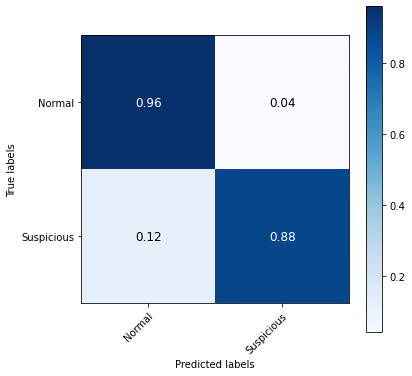

In [15]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,ypred,normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(6,6))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.savefig('both_RF_cm.pdf')
plt.show()

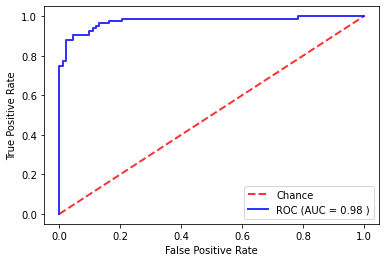

In [16]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.savefig('both_RF_ROC.pdf')
#print('AUC:',auc)

In [ ]:
acc = []
for n in range(100):
    forest_model = RandomForestClassifier(max_depth=7,n_estimators=1500,random_state=n)
    pipeline = Pipeline(steps=[('model',forest_model)])
    scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
    acc.append(scores)

In [ ]:
accs = []
for i in acc:
    accs.append(sum(i)/len(i))

In [ ]:
a = pd.DataFrame({'With Patches':accs})
a.describe()

### Cross-Validation (SVM)

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
X1 = X.loc[:, X.columns != 'Classifications']
X1 = X1.loc[:, X1.columns != 'Ratios']

In [42]:
a = scaler.fit_transform(X)
names = X.columns

In [43]:
b = pd.DataFrame(a,columns=names)
b.head()

,I_Mean,I_Std,I_Median,I_Mode,T_Entropy,I_Skewness,I_Kurtosis,Age,Classifications,Ratios,Area Factor
0,0.623361,-0.755419,0.509484,0.442045,-0.462210,0.256746,0.838282,2.685138,1.358844,1.092113,-0.189995
1,-1.088475,-0.584519,-1.150595,-0.822600,-0.587174,1.173937,0.214811,-0.669811,1.200597,1.456639,0.671500
2,0.413297,-0.898902,0.554351,0.442045,-0.679018,-1.090208,0.048425,0.336674,1.358844,0.241553,0.811580
3,-0.494543,0.467000,-0.746792,-0.822600,0.630855,0.584662,-0.783651,-0.585937,1.337265,1.213622,-0.049914
4,0.181193,1.185461,0.240282,0.442045,1.300996,-0.037961,-1.055194,-0.502063,-1.000481,-0.001464,-0.834365


In [69]:
model = svm.SVC(C=2, kernel='linear',probability=True)
pipeline = Pipeline(steps=[('model',model)])
scores = cross_val_score(pipeline, X, y,cv=5,scoring='roc_auc')
print('Accuracies: \n',scores)

Accuracies: 
 [0.92837135 0.91956783 0.95558223 0.93995098 0.97344771]


In [70]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('model', SVC(C=2, kernel='linear', probability=True))])

In [71]:
y_pred = pipeline.predict_proba(X_valid)

In [72]:
ypred = []
for i in y_pred:
    if i[0] > 0.44:
        ypred.append(0)
    else:
        ypred.append(1)

Sensitivity: 0.78
Specificity: 0.88


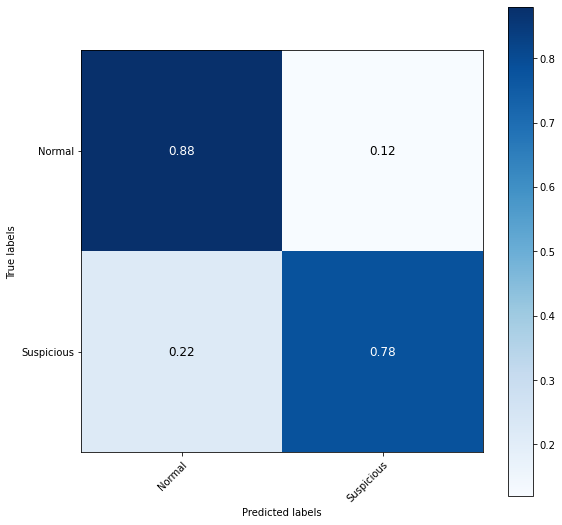

In [73]:
classes = ['Normal','Suspicious']
c = sklearn.metrics.confusion_matrix(y_valid,ypred,normalize='true')
c = numpy.around(c,decimals =2)

plt.figure(figsize=(9,9))
plt.imshow(c,cmap='Blues')

plt.xticks(numpy.arange(len(classes)),classes,rotation=45,rotation_mode="anchor",ha="right")
plt.yticks(numpy.arange(len(classes)),classes)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
for i in range(c.shape[1]):
    for j in range(c.shape[1]):
        if c[i,j]<0.5:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="black",fontsize='large')
        else:
            text = plt.text(j, i, c[i, j],
                           ha="center", va="center", color="w",fontsize='large')
#plt.title("Confusion Matrix")
plt.colorbar()
sens = c[1][1]/(c[1][1]+c[1][0])
spec = c[0][0]/(c[0][0]+c[0][1])
print('Sensitivity:',sens)
print('Specificity:',spec)
plt.savefig('full_image_svm_cm.pdf')
plt.show()

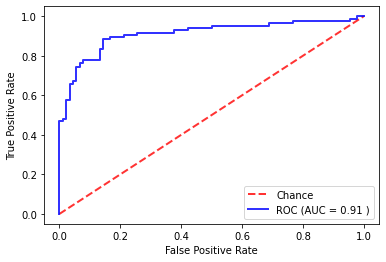

In [74]:
ypred=[]
for i in y_pred:
    ypred.append(i[1])
auc = sklearn.metrics.roc_auc_score(y_valid,ypred)
fpr,tpr,t= sklearn.metrics.roc_curve(y_valid,ypred)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.plot(fpr,tpr, color='b',
        label=r'ROC (AUC = %0.2f )' % (auc),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.savefig('full_image_svm_ROC.pdf')

In [14]:
forest_model = RandomForestClassifier(max_depth=7, n_estimators=500)
pipeline = Pipeline(steps=[('model',forest_model)])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)
ypred1=[]
for i in y_pred:
    ypred1.append(i[1])

In [15]:
model = svm.SVC(C=1.75, kernel='linear',probability=True)
pipeline = Pipeline(steps=[('model',model)])
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict_proba(X_valid)
ypred2=[]
for i in y_pred:
    ypred2.append(i[1])

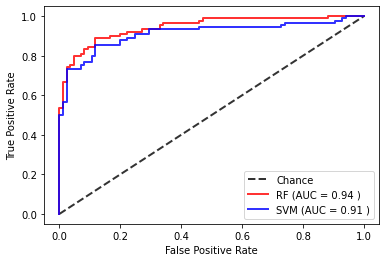

In [18]:
auc1 = sklearn.metrics.roc_auc_score(y_valid,ypred1)
auc2 = sklearn.metrics.roc_auc_score(y_valid,ypred2)
fpr1,tpr1,t= sklearn.metrics.roc_curve(y_valid,ypred1)
fpr2,tpr2,t= sklearn.metrics.roc_curve(y_valid,ypred2)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Chance', alpha=.8)
ax.plot(fpr1,tpr1, color='r',
        label=r'RF (AUC = %0.2f )' % (auc1),
        lw=2, alpha=.8)
ax.plot(fpr2,tpr2, color='b',
        label=r'SVM (AUC = %0.2f )' % (auc2),
        lw=2, alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend(loc="lower right")
#plt.show()
plt.savefig('full_image_ROC.pdf')
#print('AUC:',auc)